In [ ]:
from pathlib import Path
from scipy.io import loadmat
import sys
import os

notebook_path = os.getcwd() 
print (f"Current notebook path: {notebook_path}")
project_root = os.path.dirname(notebook_path)
if project_root not in sys.path:
    sys.path.insert(0, project_root)
print (f"Added {project_root} to sys.path")

In [2]:
import torch
import matplotlib.pyplot as plt
from utils import trainer
from utils import utils
from Systems import DynamicSystem
import Filters
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from scipy.io import loadmat
from scipy.interpolate import RegularGridInterpolator
import random

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE = device  # For backward compatibility
print(f"device: {device}")

device: cuda


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import os
import Systems


# Parametry sekvencí
TRAIN_SEQ_LEN = 50       # Délka sekvence pro trénink (např. 100 kroků = 100 sekund při 1Hz)
VAL_SEQ_LEN = 200
TEST_SEQ_LEN = 1000      # Délka sekvence pro testování (delší sekvence pro stabilnější vyhodnocení)
STRIDE = 20         # Posun okna (překryv) pro data augmentation
BATCH_SIZE = 256
DATA_PATH = 'data/processed'
print(f"Běží na zařízení: {device}")

Běží na zařízení: cuda


In [4]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import os

def prepare_sequences(dataset_list, seq_len, stride, mode='train'):
    """
    Zpracuje list trajektorií na sekvence pro trénink dle článku.
    
    Nový formát dle [Song et al., 2024]:
    - Vstup u (4D): [v_left, v_right, theta_imu, omega_imu]
    - Cíl x (6D):   [px, py, vx, vy, theta, omega]
    """
    X_seq_list = [] # Ground Truth (Cíl)
    Y_seq_list = [] # GPS Měření (Vstup do korekce)
    U_seq_list = [] # Control Input (IMU/Odo)
    
    print(f"Zpracovávám {len(dataset_list)} trajektorií pro {mode}...")
    
    for traj in dataset_list:
        # 1. Extrahuje data
        # GT z preprocessingu je [px, py, theta]
        gt = traj['ground_truth'].float() 
        
        # GPS: [x, y] (obsahuje NaN!)
        gps = traj['filtered_gps'].float()
        
        # IMU: [ax, ay, theta, omega]
        imu = traj['imu'].float()
        theta_imu = imu[:, 2] # Orientace z IMU
        omega_imu = imu[:, 3] # Úhlová rychlost z IMU
        
        # ODO: [v_left, v_right]
        odo = traj['filtered_wheel'].float()
        
        # Fix NaN v odometrii (nahradíme nulou)
        v_left = torch.nan_to_num(odo[:, 0], nan=0.0)
        v_right = torch.nan_to_num(odo[:, 1], nan=0.0)
        
        # 2. Sestavení vstupu u = [v_l, v_r, theta_imu, omega_imu] (4D)
        # Toto odpovídá "State Model" definovanému v článku (sekce II.C.2)
        u = torch.stack((v_left, v_right, theta_imu, omega_imu), dim=1)
        
        # 3. Sestavení cíle x (6D) pro state vector [px, py, vx, vy, theta, omega]
        # Vyplníme to, co máme z Ground Truth (px, py, theta).
        # Rychlosti (vx, vy, omega) v GT implicitně nemáme (nebo je složité je derivovat přesně),
        # ale pro trénink Loss funkce budeme stejně porovnávat primárně pozici.
        T = gt.shape[0]
        x_target = torch.zeros(T, 6)
        x_target[:, 0] = gt[:, 0] # px
        x_target[:, 1] = gt[:, 1] # py
        x_target[:, 4] = gt[:, 2] # theta
        # Ostatní (vx, vy, omega) zůstávají 0, protože v Loss funkci budeme maskovat nebo brát jen pozici.
        
        # 4. Sliding Window (Rozsekání na sekvence)
        num_samples = gt.shape[0]
        current_stride = stride if mode == 'train' else seq_len # U testu bez překryvu
        
        for i in range(0, num_samples - seq_len + 1, current_stride):
            # Cíl: 6D stav
            x_seq = x_target[i : i+seq_len, :]
            
            # Měření: GPS [px, py]
            y_seq = gps[i : i+seq_len, :]
            
            # Vstup: 4D control input
            u_seq = u[i : i+seq_len, :]
            
            X_seq_list.append(x_seq)
            Y_seq_list.append(y_seq)
            U_seq_list.append(u_seq)
            
    # Stack do tenzorů
    X_out = torch.stack(X_seq_list)
    Y_out = torch.stack(Y_seq_list)
    U_out = torch.stack(U_seq_list)
    
    return X_out, Y_out, U_out

# === NAČTENÍ DAT ===
# Ujistíme se, že cesty a konstanty jsou definované (pokud nejsou, doplňte je nahoře)
# if 'DATA_PATH' not in locals(): DATA_PATH = 'data/processed'
# if 'TRAIN_SEQ_LEN' not in locals(): TRAIN_SEQ_LEN = 100
# if 'VAL_SEQ_LEN' not in locals(): VAL_SEQ_LEN = 200
# if 'TEST_SEQ_LEN' not in locals(): TEST_SEQ_LEN = 500
# if 'STRIDE' not in locals(): STRIDE = 20
# if 'BATCH_SIZE' not in locals(): BATCH_SIZE = 256

train_data_raw = torch.load(os.path.join(DATA_PATH, 'train.pt'))
val_data_raw = torch.load(os.path.join(DATA_PATH, 'val.pt'))
test_data_raw = torch.load(os.path.join(DATA_PATH, 'test.pt'))
# Načtení celého balíku
# train_data_full = torch.load(os.path.join(DATA_PATH, 'train.pt'))

# === RYCHLÝ TEST: OŘÍZNUTÍ DAT ===
# Vezmeme jen prvních 5 trajektorií z 22. 
# To radikálně zrychlí jednu epochu a umožní rychle otestovat stabilitu hyperparametrů.
# train_data_raw = train_data_full[:10] 

print(f"DEBUG: Pro rychlý test používám jen {len(train_data_raw)} trajektorií.")
# ... zbytek kódu beze změny

# === PŘÍPRAVA SEKVENCÍ ===
print("--- Generuji trénovací data (Paper compatible) ---")
train_X, train_Y, train_U = prepare_sequences(train_data_raw, TRAIN_SEQ_LEN, STRIDE, 'train')

print("\n--- Generuji validační data ---")
val_X, val_Y, val_U = prepare_sequences(val_data_raw, VAL_SEQ_LEN, VAL_SEQ_LEN, 'val')

print("\n--- Generuji testovací data ---")
test_X, test_Y, test_U = prepare_sequences(test_data_raw, TEST_SEQ_LEN, TEST_SEQ_LEN, 'test')

# Vytvoření DataLoaderů
train_loader = DataLoader(TensorDataset(train_X, train_Y, train_U), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(TensorDataset(val_X, val_Y, val_U), batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(TensorDataset(test_X, test_Y, test_U), batch_size=BATCH_SIZE, shuffle=False)

print(f"\n✅ Data připravena.")
print(f"Train batches: {len(train_loader)}")
print(f"Shapes -> X: {train_X.shape} (6D State), U: {train_U.shape} (4D Input), Y: {train_Y.shape} (2D Meas)")

DEBUG: Pro rychlý test používám jen 22 trajektorií.
--- Generuji trénovací data (Paper compatible) ---
Zpracovávám 22 trajektorií pro train...

--- Generuji validační data ---
Zpracovávám 2 trajektorií pro val...

--- Generuji testovací data ---
Zpracovávám 3 trajektorií pro test...

✅ Data připravena.
Train batches: 22
Shapes -> X: torch.Size([5504, 50, 6]) (6D State), U: torch.Size([5504, 50, 4]) (4D Input), Y: torch.Size([5504, 50, 2]) (2D Meas)


In [5]:
# === INICIALIZACE DYNAMICKÉHO MODELU (System Instance - Paper Version) ===

# 1. Parametry systému podle článku [Song et al., 2024]
# State (6D): [px, py, vx, vy, theta, omega]
# Referenční rovnice (5) v článku.
state_dim = 6
# Meas (2D):  [gps_x, gps_y]
# Referenční rovnice (6) v článku.
obs_dim = 2
# Časový krok (z preprocessingu)
dt = 1.0  

# 2. Definice Matice Q (Procesní šum / Model Uncertainty)
# Nyní máme 6 stavů. Musíme definovat nejistotu pro každý z nich.
# Hodnoty jsou nastaveny heuristicky (lze ladit):
# - Pozice (idx 0,1): 0.1
# - Rychlost (idx 2,3): 0.1
# - Úhel/Omega (idx 4,5): 0.01 (IMU je v NCLT docela přesné, ale driftuje)
q_diag = torch.tensor([0.1, 0.1, 0.1, 0.1, 0.01, 0.01])
Q = torch.diag(q_diag)

# 3. Definice Matice R (Šum měření / Sensor Noise)
# GPS měří jen pozici (px, py).
# Nastavujeme 1.0 m^2. To odpovídá standardní odchylce 1m.
# Pokud je GPS v datasetu horší, KalmanNet se naučí "nedůvěřovat" vstupu y
# a spoléhat více na predikci z u (odometrie).
r_diag = torch.tensor([1.0, 1.0])
R = torch.diag(r_diag)

# 4. Počáteční podmínky (Prior)
# Ex0: Nulový vektor 6x1
Ex0 = torch.zeros(state_dim, 1)

# P0: Počáteční kovariance
# Autoři používají P k inicializaci EKF[cite: 700].
# Nastavíme rozumnou počáteční nejistotu.
P0 = torch.eye(state_dim) * 0.5

# 5. Vytvoření instance DynamicSystemNCLT
# Důležité: f=None zajistí, že se použije interní `_f_paper_dynamics` (rovnice 5),
# která očekává 4D vstup (v_l, v_r, theta, omega).
sys_model = Systems.DynamicSystemNCLT(
    state_dim=state_dim,
    obs_dim=obs_dim,
    Q=Q,
    R=R,
    Ex0=Ex0,
    P0=P0,
    dt=dt,
    f=None,  # None -> Použije se model z článku: px += vc*cos(theta_imu)...
    h=None,  # None -> Použije se GPS model: y = [px, py]
    device=DEVICE
)

print(f"✅ System Model NCLT inicializován (Paper Version).")
print(f" - State Dim: {sys_model.state_dim} [px, py, vx, vy, theta, omega]")
print(f" - Meas Dim:  {sys_model.obs_dim} [gps_x, gps_y]")
print(f" - Input Dim: 4 [v_l, v_r, theta_imu, omega_imu]") # Implicitně v modelu
print(f" - Q Diag: {q_diag.tolist()}")

✅ System Model NCLT inicializován (Paper Version).
 - State Dim: 6 [px, py, vx, vy, theta, omega]
 - Meas Dim:  2 [gps_x, gps_y]
 - Input Dim: 4 [v_l, v_r, theta_imu, omega_imu]
 - Q Diag: [0.10000000149011612, 0.10000000149011612, 0.10000000149011612, 0.10000000149011612, 0.009999999776482582, 0.009999999776482582]


In [6]:
import torch
import torch.optim as optim
import os
from state_NN_models import NCLT
from utils import trainer

state_knet = NCLT.StateKalmanNetNCLT(
    system_model=sys_model,
    device=DEVICE,
    hidden_size_multiplier=8,      # Větší kapacita pro složitější dynamiku
    output_layer_multiplier=4,
    num_gru_layers=1,               # 1 vrstva GRU obvykle stačí a je stabilnější
    gru_hidden_dim_multiplier=8
).to(DEVICE)

print(state_knet)

# state_bkn = NCLT.StateBayesianKalmanNetNCLT(
#     system_model=sys_model,
#     device=DEVICE,
#     hidden_size_multiplier=8,      # Větší kapacita pro složitější dynamiku
#     output_layer_multiplier=4,
#     num_gru_layers=1,               # 1 vrstva GRU obvykle stačí a je stabilnější
#     init_min_dropout=0.2,
#     init_max_dropout=0.4
# ).to(DEVICE)

state_bkn = NCLT.StateBayesianKalmanNetNCLT_test(
    system_model=sys_model,
    device=DEVICE,
    hidden_size_multiplier=10,      # Větší kapacita pro složitější dynamiku
    output_layer_multiplier=4,
    num_gru_layers=1,               # 1 vrstva GRU obvykle stačí a je stabilnější
    init_min_dropout=0.4,
    init_max_dropout=0.6
).to(DEVICE)
print(state_bkn)

kalman_former = NCLT.KalmanFormerNCLT(
    system_model=sys_model,
    device=DEVICE,
    d_model=64,
    nhead=4,
    num_encoder_layers=2,
    num_decoder_layers=2,
    dim_feedforward=256,
    dropout=0.25
).to(DEVICE)

print(kalman_former)


DEBUG: Layer 'output_final_linear.0' initialized near zero (Start K=0).
StateKalmanNetNCLT(
  (dnn): DNN_KalmanNetNCLT(
    (input_layer): Sequential(
      (0): Linear(in_features=16, out_features=512, bias=True)
      (1): ReLU()
    )
    (gru): GRU(512, 320)
    (output_hidden_layer): Sequential(
      (0): Linear(in_features=320, out_features=48, bias=True)
      (1): ReLU()
    )
    (output_final_linear): Sequential(
      (0): Linear(in_features=48, out_features=12, bias=True)
    )
  )
)
INFO: Aplikuji 'Start Zero' inicializaci pro Kalman Gain.
DEBUG: Výstupní vrstva vynulována (Soft Start).
StateBayesianKalmanNetNCLT_test(
  (dnn): DNN_BayesianKalmanNetNCLT_test(
    (input_layer): Sequential(
      (0): Linear(in_features=16, out_features=640, bias=True)
      (1): ReLU()
    )
    (concrete_dropout1): ConcreteDropout()
    (gru): GRU(640, 160)
    (output_layer): Sequential(
      (0): Linear(in_features=160, out_features=48, bias=True)
      (1): ReLU()
      (2): Linear(i

In [ ]:
import os
import torch

# ==========================================
# 1. NASTAVENÍ NÁZVŮ SOUBORŮ (Manuální vstup)
# ==========================================
# Složka, kde jsou váhy uloženy
WEIGHTS_DIR = 'NN_weights/complex'

# Zde doplň přesné názvy souborů .pth
# KNET_FILENAME = 'best_Knet_test_results.pth'                                          # Příklad
KNET_FILENAME = 'best_Knet_test_results.pth'
BKN_FILENAME = 'best_BKN_test_results_legal.pth'                                            # Doplň název
FORMER_FILENAME = 'best_KalmanFormer_test_results.pth'                                # Doplň název

# ==========================================
# 2. FUNKCE PRO BEZPEČNÉ NAČTENÍ
# ==========================================
def load_pretrained_weights(model, filename, model_name):
    filepath = os.path.join(WEIGHTS_DIR, filename)
    
    if not os.path.exists(filepath):
        print(f"⚠️  VAROVÁNÍ: Soubor '{filename}' pro {model_name} nebyl nalezen v '{WEIGHTS_DIR}'.")
        return

    try:
        # Načtení na správné zařízení (CPU/GPU)
        checkpoint = torch.load(filepath, map_location=DEVICE)
        
        # Detekce, zda jde o čistý state_dict nebo slovník checkpointu
        if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
            # Pokud je to checkpoint z traineru, vytáhneme jen váhy modelu
            state_dict = checkpoint['model_state_dict']
        elif isinstance(checkpoint, dict) and 'state_dict' in checkpoint:
            state_dict = checkpoint['state_dict']
        else:
            # Předpokládáme, že je to přímo state_dict
            state_dict = checkpoint

        # Nahrání vah do modelu
        model.load_state_dict(state_dict)
        
        # Důležité: Přepnutí do evaluačního módu (vypne Dropout, fixuje BatchNorm)
        model.eval()
        
        print(f"✅ {model_name}: Váhy úspěšně načteny z '{filename}'.")
        
    except Exception as e:
        print(f"❌ CHYBA: Nepodařilo se načíst váhy pro {model_name}.\n   Důvod: {e}")

# ==========================================
# 3. SPUŠTĚNÍ NAČÍTÁNÍ
# ==========================================
print(f"--- Načítání vah ze složky: {os.path.abspath(WEIGHTS_DIR)} ---\n")

# Načtení State KalmanNet
load_pretrained_weights(state_knet, KNET_FILENAME, "State KalmanNet")

# Načtení Bayesian KalmanNet
load_pretrained_weights(state_bkn, BKN_FILENAME, "State BKN")

# Načtení KalmanFormer
load_pretrained_weights(kalman_former, FORMER_FILENAME, "KalmanFormer")

print("\n--- Hotovo ---")

--- Načítání vah ze složky: /home/luky/skola/KalmanNet-main/navigation NCLT dataset/NN_weights ---

✅ State KalmanNet: Váhy úspěšně načteny z 'best_Knet_test_results.pth'.
✅ State BKN: Váhy úspěšně načteny z 'best_BKN_test_results_legal.pth'.
✅ KalmanFormer: Váhy úspěšně načteny z 'best_KalmanFormer_test_results.pth'.

--- Hotovo ---


INFO: Nastaveno sys_model.dt = 1.0 s
INFO: BKN připraven (J=50).
INFO: KalmanNet připraven.
INFO: KalmanFormer připraven.
INFO: Particle Filter připraven (N=50000).

Spouštím evaluaci na 3 trajektoriích...
Traj 1 | RMSE [m]: EKF:21.05, UKF:20.99, PF:19.86, KNet:12.78, BKN:15.77, Form:16.69


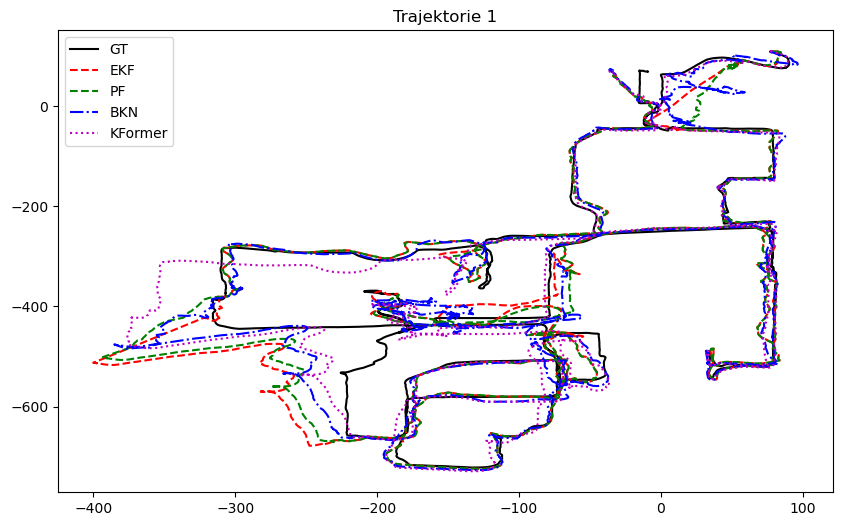

Traj 2 | RMSE [m]: EKF:14.89, UKF:14.89, PF:9.24, KNet:6.68, BKN:9.56, Form:9.01
Traj 3 | RMSE [m]: EKF:11.33, UKF:11.34, PF:8.64, KNet:6.07, BKN:7.66, Form:5.87

                                        TABULKA 1: Detailní výsledky po trajektoriích                                        
ID   | EKF MSE   ANEES   | UKF MSE   ANEES   | PF MSE    ANEES   | BKN MSE   ANEES   | KNet MSE  | Form MSE 
-----------------------------------------------------------------------------------------------------------------------------
1    | 443.11    1027.02 | 440.44    1026.75 | 394.25    79893.20 | 248.82    22.37   | 163.35    | 278.58   
2    | 221.68    445.10  | 221.82    445.09  | 85.38     13546.73 | 91.38     39.73   | 44.64     | 81.13    
3    | 128.44    311.25  | 128.70    311.28  | 74.73     682.37  | 58.68     102.45  | 36.83     | 34.46    

                  TABULKA 2: Souhrnné průměrné výsledky (Mean across trajectories)                  
Metoda          | MSE (avg)    | RMSE (avg)  

/tmp/ipykernel_87885/4216826297.py:289: RuntimeWarning: Mean of empty slice
  mean_anees = np.nanmean(anees_list)


In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import sys

# ==============================================================================
# 0. KONFIGURACE A MODEL
# ==============================================================================
DT_SEC = 1.0 
J_SAMPLES = 50  # Počet vzorků pro BKN (MC Dropout)
NUM_PARTICLES = 50000 # Počet částic pro PF

if hasattr(sys_model, 'dt'):
    sys_model.dt = DT_SEC
    print(f"INFO: Nastaveno sys_model.dt = {DT_SEC} s")

# --- KONTROLA A PŘÍPRAVA NN MODELŮ ---
models_to_eval = {}

# 1. Bayesian KalmanNet
try:
    state_bkn.eval()
    models_to_eval['BKN'] = state_bkn
    print(f"INFO: BKN připraven (J={J_SAMPLES}).")
except NameError:
    print("WARNING: 'state_bkn' nenalezen.")

# 2. State KalmanNet (Standard)
try:
    state_knet.eval()
    models_to_eval['KNet'] = state_knet
    print("INFO: KalmanNet připraven.")
except NameError:
    print("WARNING: 'state_knet' nenalezen.")

# 3. KalmanFormer
try:
    kalman_former.eval()
    models_to_eval['KFormer'] = kalman_former
    print("INFO: KalmanFormer připraven.")
except NameError:
    print("WARNING: 'kalman_former' nenalezen.")

from Filters import NCLT
# Pokud máš PF v Filters.py, importuj ho, jinak se předpokládá definice výše
# from Filters import ParticleFilterNCLT 

# --- INICIALIZACE KLASICKÝCH FILTRŮ ---
ukf_filter = NCLT.UnscentedKalmanFilterNCLT(sys_model) 
ekf_filter = NCLT.ExtendedKalmanFilterNCLT(sys_model)
# Inicializace PF (používáme opravenou třídu z minula)
try:
    pf_filter = NCLT.AuxiliaryParticleFilterNCLT(sys_model, num_particles=NUM_PARTICLES)
    print(f"INFO: Particle Filter připraven (N={NUM_PARTICLES}).")
except NameError:
    print("ERROR: Třída ParticleFilterNCLT nenalezena! Ujisti se, že je definována.")
    pf_filter = None

# --- ROBUSTNÍ FUNKCE PRO ANEES ---
def calculate_anees(x_true, x_est, P_est):
    T = x_true.shape[0]
    anees_list = []
    error = x_true - x_est 
    for t in range(T):
        e_t = error[t].unsqueeze(1) # [n, 1]
        P_t = P_est[t]              # [n, n]
        try:
            P_inv = torch.linalg.pinv(P_t, hermitian=True)
        except RuntimeError:
            P_inv = torch.eye(P_t.shape[0], device=P_t.device)
        nees = torch.mm(torch.mm(e_t.t(), P_inv), e_t).item()
        anees_list.append(nees)
    return np.mean(anees_list)

def get_mse(pred, target):
    return F.mse_loss(pred[:, :2], target[:, :2]).item()

# ==============================================================================
# 1. EVALUACE TRAJEKTORIÍ
# ==============================================================================
# Úložiště výsledků pro finální tabulku
metrics_storage = {
    'BKN': {'MSE': [], 'ANEES': []},
    'EKF': {'MSE': [], 'ANEES': []},
    'UKF': {'MSE': [], 'ANEES': []},
    'PF':  {'MSE': [], 'ANEES': []},
    'KNet': {'MSE': [], 'ANEES': []},   # ANEES bude vždy NaN
    'KFormer': {'MSE': [], 'ANEES': []}, # ANEES bude vždy NaN
    'GPS': {'MSE': [], 'ANEES': []}
}

print(f"\nSpouštím evaluaci na {len(test_data_raw)} trajektoriích...")

for i, traj in enumerate(test_data_raw):
    # --- PŘÍPRAVA DAT ---
    gt_raw = traj['ground_truth'].float().to(DEVICE)
    gps_filtered = traj['filtered_gps'].float().to(DEVICE) # S NaNs
    imu_raw = traj['imu'].float().to(DEVICE)
    odo_raw = traj['filtered_wheel'].float().to(DEVICE)
    T_len = gt_raw.shape[0]
    if 'gps' in traj:
        gps_raw_metric = traj['gps'].float().to(DEVICE)
    else:
        gps_raw_metric = gps_filtered # Fallback
    # Input vector [v_left, v_right, ax, ay] -> nebo jak je definováno v modelu
    u_full = torch.stack((
        torch.nan_to_num(odo_raw[:, 0], nan=0.0),
        torch.nan_to_num(odo_raw[:, 1], nan=0.0),
        imu_raw[:, 2], 
        imu_raw[:, 3]
    ), dim=1).to(DEVICE)
    
    # Pro NN modely (KNet, KFormer, BKN) nesmí být v 'u' NaNs (už vyřešeno nahoře)
    # A pro měření 'y' nahradíme NaNs nulou (standardní postup pro KNet), maska se řeší interně nebo se to ignoruje
    # y_nn = torch.nan_to_num(gps_filtered, nan=0.0)

    # Ground Truth State (X, Y, Theta)
    x_true = gt_raw[:, :3] 
    
    # Init pro filtry
    m = sys_model.state_dim
    x0_vec = torch.zeros(m).to(DEVICE)
    x0_vec[0] = x_true[0, 0]; x0_vec[1] = x_true[0, 1]
    if m >= 3 and x_true.shape[1] >= 3: x0_vec[4] = x_true[0, 2] 
    x0_batch = x0_vec.unsqueeze(0)

    # --------------------------------------------------------------------------
    # A. BĚH MODELŮ S NEJISTOTOU (BKN, EKF, UKF, PF)
    # --------------------------------------------------------------------------
    
    # 1. BKN (Bayesian KalmanNet)
    x_bkn_mean, P_bkn = None, None
    if 'BKN' in models_to_eval:
        models_to_eval['BKN'].train() # Enable Dropout
        batch_x0_bkn = x0_vec.unsqueeze(0).repeat(J_SAMPLES, 1)
        models_to_eval['BKN'].reset(batch_size=J_SAMPLES, initial_state=batch_x0_bkn)
        
        bkn_samples = [batch_x0_bkn.unsqueeze(1)]
        with torch.no_grad():
            for t in range(1, T_len):
                # BKN potřebuje [Batch, Dim]
                y_t = gps_filtered[t].unsqueeze(0).repeat(J_SAMPLES, 1)
                u_t = u_full[t].unsqueeze(0).repeat(J_SAMPLES, 1)
                x_est_j, _ = models_to_eval['BKN'].step(y_t, u_t)
                bkn_samples.append(x_est_j.unsqueeze(1))
        
        bkn_ensemble = torch.cat(bkn_samples, dim=1) # [J, T, m]
        x_bkn_mean = torch.mean(bkn_ensemble, dim=0) 
        # Covariance approx
        centered = bkn_ensemble - x_bkn_mean.unsqueeze(0)
        centered_perm = centered.permute(1, 2, 0) 
        P_bkn = torch.bmm(centered_perm, centered_perm.transpose(1, 2)) / (J_SAMPLES - 1)
        P_bkn = P_bkn + torch.eye(m, device=DEVICE).unsqueeze(0) * 1e-6 
        models_to_eval['BKN'].eval()

    # 2. & 3. EKF & UKF
    def run_filter(flt):
        try:
            res = flt.process_sequence(gps_filtered, u_seq=u_full, Ex0=x0_vec, P0=sys_model.P0)
            return res['x_filtered'], res.get('P_filtered', None)
        except Exception as e:
            return torch.zeros(T_len, m).to(DEVICE), None

    x_ekf, P_ekf = run_filter(ekf_filter)
    x_ukf, P_ukf = run_filter(ukf_filter)
    
    # 4. Particle Filter
    x_pf, P_pf = None, None
    if pf_filter is not None:
        try:
            # Pozor na pojmenování argumentu u_sequence vs u_seq
            res_pf = pf_filter.process_sequence(gps_filtered, u_sequence=u_full, Ex0=x0_vec, P0=sys_model.P0)
            x_pf = res_pf['x_filtered']
            P_pf = res_pf['P_filtered']
        except Exception as e:
            # print(f"PF Error: {e}")
            x_pf = torch.zeros(T_len, m).to(DEVICE)

    # --------------------------------------------------------------------------
    # B. BĚH MODELŮ BEZ NEJISTOTY (KNet, KFormer)
    # --------------------------------------------------------------------------
    
    def run_nn_simple(model):
        model.reset(batch_size=1, initial_state=x0_batch)
        path = [x0_batch]
        with torch.no_grad():
            for t in range(1, T_len):
                x_step = model.step(gps_filtered[t].unsqueeze(0), u_full[t].unsqueeze(0))
                path.append(x_step)
        return torch.cat(path, dim=0)

    x_knet = run_nn_simple(models_to_eval['KNet']) if 'KNet' in models_to_eval else None
    x_former = run_nn_simple(models_to_eval['KFormer']) if 'KFormer' in models_to_eval else None

    # --------------------------------------------------------------------------
    # C. VYHODNOCENÍ METRIK
    # --------------------------------------------------------------------------
    eval_dim = x_true.shape[1] # 3 (X, Y, Theta)

    def calc_metrics(name, est_x, est_P=None):
        if est_x is None: return np.nan, np.nan
        
        # 1. MSE
        mse_val = get_mse(est_x, x_true)
        metrics_storage[name]['MSE'].append(mse_val)
        
        # 2. ANEES (jen pokud máme P)
        anees_val = np.nan
        if est_P is not None:
            est_x_sliced = est_x[:, :eval_dim]
            est_P_sliced = est_P[:, :eval_dim, :eval_dim]
            anees_val = calculate_anees(x_true, est_x_sliced, est_P_sliced)
            metrics_storage[name]['ANEES'].append(anees_val)
        else:
            metrics_storage[name]['ANEES'].append(np.nan) # Placeholder
            
        return mse_val, anees_val

    # Výpočet pro všechny
    mse_bkn, anees_bkn = calc_metrics('BKN', x_bkn_mean, P_bkn)
    mse_ekf, anees_ekf = calc_metrics('EKF', x_ekf, P_ekf)
    mse_ukf, anees_ukf = calc_metrics('UKF', x_ukf, P_ukf)
    mse_pf, anees_pf   = calc_metrics('PF', x_pf, P_pf)
    mse_knet, _        = calc_metrics('KNet', x_knet, None)
    mse_form, _        = calc_metrics('KFormer', x_former, None)

    # GPS Metriky
    # valid_mask = ~torch.isnan(gps_filtered[:, 0])
    # mse_gps = F.mse_loss(gps_filtered[valid_mask], x_true[valid_mask, :2]).item() if valid_mask.sum() > 0 else np.nan
    # metrics_storage['GPS']['MSE'].append(mse_gps)
    
    mse_gps = F.mse_loss(gps_raw_metric[:, :2], x_true[:, :2]).item()
    metrics_storage['GPS']['MSE'].append(mse_gps)
    # --------------------------------------------------------------------------
    # D. VÝPIS PO TRAJEKTORII
    # --------------------------------------------------------------------------
    print(f"Traj {i+1} | RMSE [m]: EKF:{np.sqrt(mse_ekf):.2f}, UKF:{np.sqrt(mse_ukf):.2f}, PF:{np.sqrt(mse_pf):.2f}, KNet:{np.sqrt(mse_knet):.2f}, BKN:{np.sqrt(mse_bkn):.2f}, Form:{np.sqrt(mse_form):.2f}")

    # (Volitelně) Zobrazit graf jen pro první trajektorii nebo náhodně
    if i == 0:
        fig, ax = plt.subplots(figsize=(10, 6))
        gt = x_true.cpu().numpy()
        ax.plot(gt[:,0], gt[:,1], 'k-', label='GT')
        if x_ekf is not None: ax.plot(x_ekf.cpu().numpy()[:,0], x_ekf.cpu().numpy()[:,1], 'r--', label='EKF')
        if x_pf is not None: ax.plot(x_pf.cpu().numpy()[:,0], x_pf.cpu().numpy()[:,1], 'g--', label='PF')
        if x_bkn_mean is not None: ax.plot(x_bkn_mean.cpu().numpy()[:,0], x_bkn_mean.cpu().numpy()[:,1], 'b-.', label='BKN')
        if x_former is not None: ax.plot(x_former.cpu().numpy()[:,0], x_former.cpu().numpy()[:,1], 'm:', label='KFormer')
        ax.legend()
        ax.set_title(f"Trajektorie {i+1}")
        plt.show()

# ==============================================================================
# 2. FINÁLNÍ TABULKY
# ==============================================================================

# --- TABULKA 1: DETAILNÍ VÝSLEDKY PO TRAJEKTORIÍCH ---
print("\n" + "="*125)
print(f"{'TABULKA 1: Detailní výsledky po trajektoriích':^125}")
print("="*125)
header = f"{'ID':<4} | {'EKF MSE':<9} {'ANEES':<7} | {'UKF MSE':<9} {'ANEES':<7} | {'PF MSE':<9} {'ANEES':<7} | {'BKN MSE':<9} {'ANEES':<7} | {'KNet MSE':<9} | {'Form MSE':<9}"
print(header)
print("-" * 125)

n_traj = len(test_data_raw)
for i in range(n_traj):
    row_str = f"{i+1:<4} | "
    for model in ['EKF', 'UKF', 'PF', 'BKN']:
        m = metrics_storage[model]['MSE'][i]
        a = metrics_storage[model]['ANEES'][i]
        row_str += f"{m:<9.2f} {a:<7.2f} | "
    
    # Modely bez ANEES
    m_knet = metrics_storage['KNet']['MSE'][i]
    m_form = metrics_storage['KFormer']['MSE'][i]
    row_str += f"{m_knet:<9.2f} | {m_form:<9.2f}"
    
    print(row_str)

# --- TABULKA 2: PRŮMĚRNÉ VÝSLEDKY ---
print("\n" + "="*100)
print(f"{'TABULKA 2: Souhrnné průměrné výsledky (Mean across trajectories)':^100}")
print("="*100)
print(f"{'Metoda':<15} | {'MSE (avg)':<12} | {'RMSE (avg)':<12} | {'ANEES (avg)':<12}")
print("-" * 100)

for model_name in ['GPS', 'EKF', 'UKF', 'PF', 'BKN', 'KNet', 'KFormer']:
    mse_list = metrics_storage[model_name]['MSE']
    anees_list = metrics_storage[model_name]['ANEES']
    
    # Výpočet průměrů (ignorování NaN)
    mean_mse = np.nanmean(mse_list)
    mean_rmse = np.sqrt(mean_mse) # RMSE počítáme jako odmocninu průměrného MSE
    mean_anees = np.nanmean(anees_list)
    
    anees_str = f"{mean_anees:.2f}" if not np.isnan(mean_anees) else "-"
    
    print(f"{model_name:<15} | {mean_mse:<12.2f} | {mean_rmse:<12.2f} | {anees_str:<12}")

print("="*100)

🚀 Spouštím detailní analýzu neurčitosti pro trajektorii č. 2...
Spouštím BKN inference...
Spouštím EKF inference...
Spouštím PF inference...


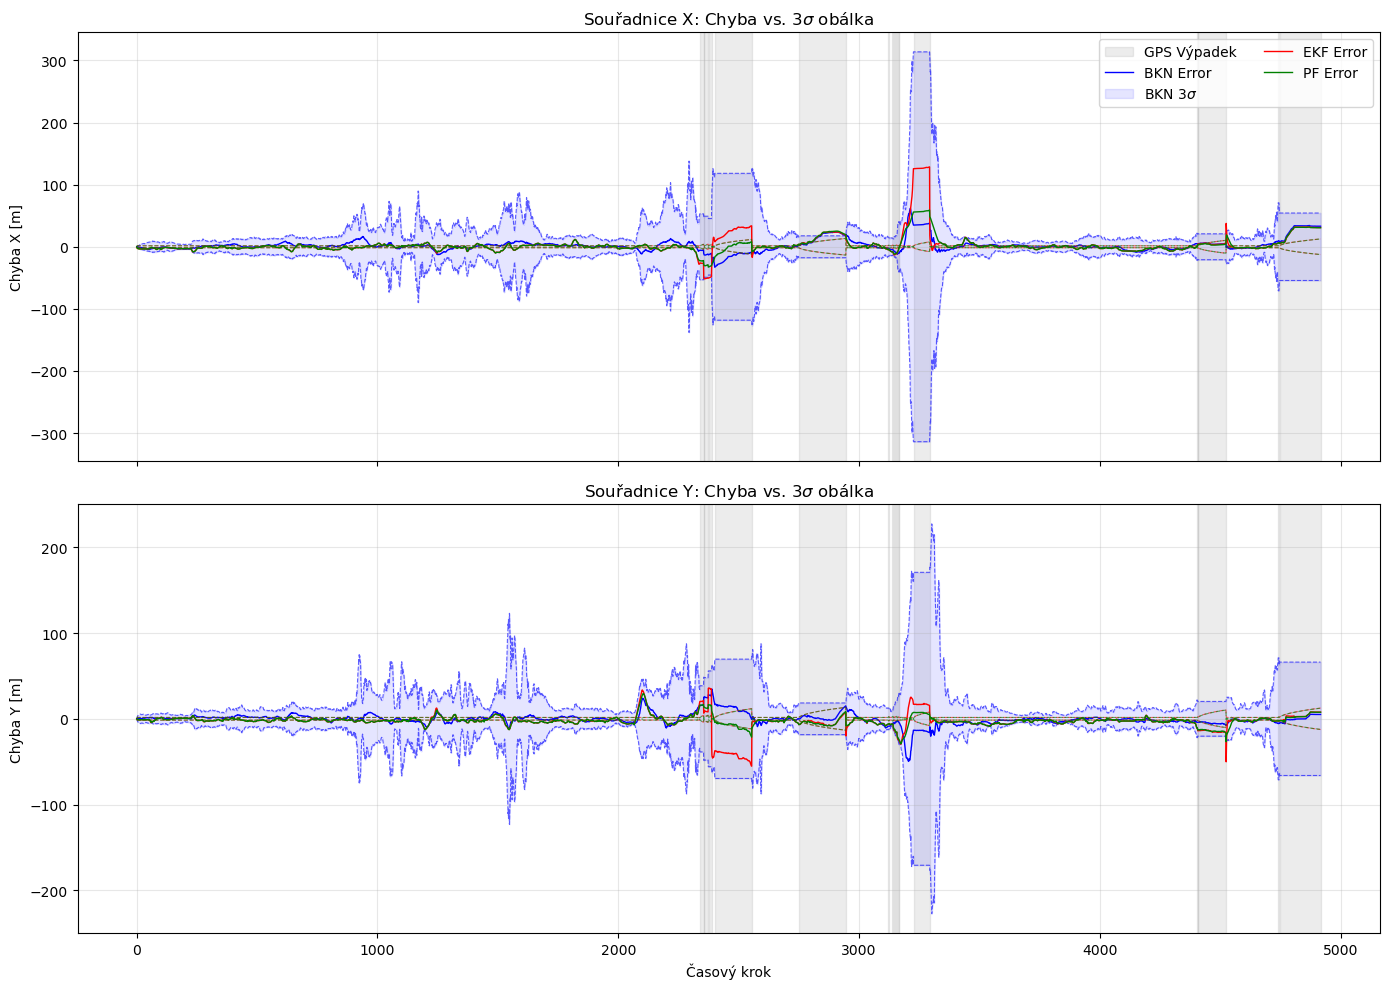

Analýza dokončena. Šedé zóny v grafech značí místa bez GPS signálu.


In [11]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection

# ==============================================================================
# 1. KONFIGURACE A PŘÍPRAVA DAT (2. TRAJEKTORIE)
# ==============================================================================
TRAJ_IDX = 1  # Index druhé trajektorie
J_SAMPLES = 50 # Počet vzorků pro BKN
PLOT_SIGMA = 3 # 3-sigma (cca 99.7% confidence)
STEP_ELLIPSE = 300 # Kreslit elipsu každých X kroků (pro přehlednost)
pf_filter = NCLT.AuxiliaryParticleFilterNCLT(sys_model, num_particles=10000)
print(f"🚀 Spouštím detailní analýzu neurčitosti pro trajektorii č. {TRAJ_IDX + 1}...")

# Načtení dat trajektorie
traj_data = test_data_raw[TRAJ_IDX]
gt_raw = traj_data['ground_truth'].float().to(DEVICE)     # [T, 3] (x, y, theta)
gps_filtered = traj_data['filtered_gps'].float().to(DEVICE) # [T, 2] (s NaNs)
imu_raw = traj_data['imu'].float().to(DEVICE)
odo_raw = traj_data['filtered_wheel'].float().to(DEVICE)

# Input vector [v_left, v_right, ax, ay]
u_full = torch.stack((
    torch.nan_to_num(odo_raw[:, 0], nan=0.0),
    torch.nan_to_num(odo_raw[:, 1], nan=0.0),
    imu_raw[:, 2], 
    imu_raw[:, 3]
), dim=1).to(DEVICE)

T_len = gt_raw.shape[0]

# Ground Truth State
x_true = gt_raw[:, :3]

# Init State
m = sys_model.state_dim
x0_vec = torch.zeros(m).to(DEVICE)
x0_vec[0] = x_true[0, 0]; x0_vec[1] = x_true[0, 1]
if m >= 3 and x_true.shape[1] >= 3: x0_vec[4] = x_true[0, 2] # Theta

# Maska výpadků GPS (True tam, kde GPS chybí)
gps_nan_mask = torch.isnan(gps_filtered[:, 0]).cpu().numpy()

# ==============================================================================
# 2. INFERENCE MODELŮ (BKN, EKF, PF)
# ==============================================================================
results = {}

# --- A. BKN (Bayesian KalmanNet) ---
if 'state_bkn' in locals() or 'state_bkn' in globals():
    print("Spouštím BKN inference...")
    state_bkn.train() # Enable Dropout
    batch_x0 = x0_vec.unsqueeze(0).repeat(J_SAMPLES, 1)
    state_bkn.reset(batch_size=J_SAMPLES, initial_state=batch_x0)
    
    bkn_samples = [batch_x0.unsqueeze(1)]
    with torch.no_grad():
        for t in range(1, T_len):
            # Expand inputs for batch
            y_t = gps_filtered[t].unsqueeze(0).repeat(J_SAMPLES, 1)
            u_t = u_full[t].unsqueeze(0).repeat(J_SAMPLES, 1)
            x_est_j, _ = state_bkn.step(y_t, u_t)
            bkn_samples.append(x_est_j.unsqueeze(1))
    
    # Statistika ensamblu
    bkn_ens = torch.cat(bkn_samples, dim=1) # [J, T, m]
    x_mean = torch.mean(bkn_ens, dim=0)
    
    # Výpočet kovariance [T, m, m]
    centered = bkn_ens - x_mean.unsqueeze(0)
    centered = centered.permute(1, 2, 0) # [T, m, J]
    P_bkn = torch.bmm(centered, centered.transpose(1, 2)) / (J_SAMPLES - 1)
    
    results['BKN'] = {'x': x_mean.cpu().numpy(), 'P': P_bkn.cpu().numpy(), 'color': 'blue'}
    state_bkn.eval()

# --- B. EKF ---
if 'ekf_filter' in locals() or 'ekf_filter' in globals():
    print("Spouštím EKF inference...")
    try:
        res_ekf = ekf_filter.process_sequence(gps_filtered, u_seq=u_full, Ex0=x0_vec, P0=sys_model.P0)
        results['EKF'] = {'x': res_ekf['x_filtered'].cpu().numpy(), 
                          'P': res_ekf['P_filtered'].cpu().numpy(), 
                          'color': 'red'}
    except Exception as e: print(f"EKF chyba: {e}")

# --- C. Particle Filter ---
if 'pf_filter' in locals() or 'pf_filter' in globals() and pf_filter is not None:
    print("Spouštím PF inference...")
    try:
        res_pf = pf_filter.process_sequence(gps_filtered, u_sequence=u_full, Ex0=x0_vec, P0=sys_model.P0)
        results['PF'] = {'x': res_pf['x_filtered'].cpu().numpy(), 
                         'P': res_pf['P_filtered'].cpu().numpy(), 
                         'color': 'green'}
    except Exception as e: print(f"PF chyba: {e}")


# ==============================================================================
# 3. VIZUALIZACE
# ==============================================================================
gt_np = x_true.cpu().numpy()
gps_np = gps_filtered.cpu().numpy()

# Pomocná funkce pro elipsy
def get_cov_ellipse(px, py, cov, n_std=3.0, **kwargs):
    cov_2d = cov[:2, :2]
    vals, vecs = np.linalg.eigh(cov_2d)
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
    width, height = 2 * n_std * np.sqrt(np.abs(vals))
    return patches.Ellipse(xy=(px, py), width=width, height=height, angle=theta, **kwargs)

# # --- GRAF 1: TRAJEKTORIE X-Y ---
# fig1, ax1 = plt.subplots(figsize=(12, 10))

# # Vykreslení Ground Truth
# ax1.plot(gt_np[:, 0], gt_np[:, 1], 'k-', linewidth=2, label='Ground Truth', zorder=1)

# # Vykreslení dostupných GPS bodů (pro kontrolu výpadků)
# # Zobrazíme jen ty, které nejsou NaN
# valid_gps = ~np.isnan(gps_np[:, 0])
# ax1.scatter(gps_np[valid_gps, 0], gps_np[valid_gps, 1], c='gray', s=5, alpha=0.3, label='Dostupné GPS', zorder=0)

# # Vykreslení modelů a elips
# for name, res in results.items():
#     # Trajektorie
#     ax1.plot(res['x'][:, 0], res['x'][:, 1], color=res['color'], label=f'{name} Mean', linewidth=1.5)
    
#     # Elipsy neurčitosti
#     for t in range(0, T_len, STEP_ELLIPSE):
#         if not np.isnan(res['P'][t]).any():
#             ell = get_cov_ellipse(res['x'][t, 0], res['x'][t, 1], res['P'][t], n_std=PLOT_SIGMA,
#                                   edgecolor=res['color'], facecolor='none', linewidth=1.5, alpha=0.7)
#             ax1.add_patch(ell)

# ax1.set_title(f"Trajektorie {TRAJ_IDX+1}: Neurčitost a GPS výpadky", fontsize=14)
# ax1.set_xlabel("X [m]")
# ax1.set_ylabel("Y [m]")
# ax1.axis('equal')
# ax1.grid(True, alpha=0.3)
# ax1.legend()

# --- GRAF 2: CHYBA A NEURČITOST V ČASE (X a Y) ---
fig2, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)
coords = ['X', 'Y']

for i, ax in enumerate(axes):
    ax.set_title(f"Souřadnice {coords[i]}: Chyba vs. {PLOT_SIGMA}$\sigma$ obálka", fontsize=12)
    
    # Zvýraznění výpadků GPS (šedé pozadí)
    # Najdeme intervaly, kde gps_nan_mask je True
    is_nan = np.concatenate(([0], gps_nan_mask, [0]))
    abs_diff = np.abs(np.diff(is_nan))
    ranges = np.where(abs_diff == 1)[0].reshape(-1, 2)
    
    for start, end in ranges:
        ax.axvspan(start, end, color='gray', alpha=0.15, label='GPS Výpadek' if start == ranges[0][0] and i==0 else "")

    # Vykreslení modelů
    for name, res in results.items():
        # Chyba = GT - Odhad
        error = gt_np[:, i] - res['x'][:, i]
        
        # Obálka (3 sigma) = 3 * sqrt(Variance)
        sigma = np.sqrt(res['P'][:, i, i])
        bound_upper = PLOT_SIGMA * sigma
        bound_lower = -PLOT_SIGMA * sigma
        
        # Plot chyby
        ax.plot(error, color=res['color'], label=f'{name} Error', linewidth=1)
        
        # Plot obálky (dashed)
        ax.plot(bound_upper, color=res['color'], linestyle='--', linewidth=0.8, alpha=0.6)
        ax.plot(bound_lower, color=res['color'], linestyle='--', linewidth=0.8, alpha=0.6)
        
        # Výplň pro lepší viditelnost (hlavně u BKN)
        if name == 'BKN':
            ax.fill_between(range(T_len), bound_lower, bound_upper, color=res['color'], alpha=0.1, label=f'BKN {PLOT_SIGMA}$\sigma$')

    ax.set_ylabel(f"Chyba {coords[i]} [m]")
    ax.grid(True, alpha=0.3)
    if i == 0:
        # Legenda jen nahoře
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles)) # Odstranění duplicit (pro GPS výpadky)
        ax.legend(by_label.values(), by_label.keys(), loc='upper right', ncol=2)

axes[-1].set_xlabel("Časový krok")
plt.tight_layout()
plt.show()

print("Analýza dokončena. Šedé zóny v grafech značí místa bez GPS signálu.")